Train Neural Networks to estimate Likelihood Ratios
===

In this notebook we will setup the neural networks that train unbiased and low-variance density ratios to be then used for inference. The statistical model we have is: 

$$p(x|\mu, \alpha) = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot p_c\left(x|\alpha\right)$$

where $c$ stands for the various physics channels that contribute to the final state $x$, $\mu$ is the signal-strength parameter and $\alpha$ is the vector of nuisance parameters associated with the various systematic uncertainties in the model. Note that we are assuming that the parameter $\mu$-dependence is known analytically and that we have simulation models for each of the channels $p_c(x)$. 

The objective is to build the test statistic for composite hypothesis testing:

$$t_\mu = -2 \ln \frac{p(x|\mu, \hat{\hat{\alpha}})}{p(x|\hat{\mu}, \hat{\alpha})}$$

A direct approach would then be to model the probability density $p(x|\mu, \alpha)$ using NNs. But that is a more difficult task than training probability density ratios. We use a simple trick:

$$t_\mu = -2 \ln \frac{p(x|\mu, \hat{\hat{\alpha}})/p_{ref}(x)}{p(x|\hat{\mu}, \hat{\alpha})/p_{ref}(x)}$$

to turn this into a density ratio estimation problem:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot \frac{p_c\left(x|\alpha\right)}{p_{ref}(x)}$$

Factorizing out the $\alpha$-dependence in the density ratios:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

Furthermore, instead of training NNs parameterized on $\mu$ and $\alpha$, we use analytical parameterizations to simplify the problem to training only parameter-independent density ratios.

Let's set this up for the ttbar dataset!

In [56]:
import os, sys, importlib
sys.path.append('../')

import common_utils
from common_utils import plotting, training
from common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use(hep.style.ATLAS)

In [57]:
# Load the datasets from pre-processed input
saved_data='./cached_data/'

training_features = np.load(f"{saved_data}features.npy")
train_labels = np.load(f"{saved_data}train_labels.npy")
weights = np.load(f"{saved_data}weights.npy")

In [58]:
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "wjets":2}

In [59]:
type_vec = np.array(train_labels, dtype='object')

for key in labels_dict:
    type_vec[type_vec==labels_dict[key]] = key


In [60]:
# Build a pandas dataframe from the arrays for density ratio training and validation
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi']
# columns = ['lepton_pt', 'lepton_eta', 'lepton_phi', 'H_T']
dataset_incl = pd.DataFrame(training_features, columns=columns)

# Some scaling to reduce the spread of pt distributions 
dataset_incl['log_lepton_pt'] = np.log(dataset_incl['lepton_pt'].ravel())
# dataset_incl['log_H_T'] = np.log(dataset_incl['H_T'].ravel()+1.0) # Add the one to compensate to avoid log of 0

# Some scaling to reduce the spread of pt distributions 
dataset_incl['train_labels_presel'] = train_labels
dataset_incl['type'] = type_vec
dataset_incl['weights'] = weights

In [61]:
# Normalizing the training weights - only discriminating shapes, not norms

weights_normed = weights.copy()

for key in labels_dict:

    weights_normed[train_labels==labels_dict[key]] /= weights[train_labels==labels_dict[key]].sum()

dataset_incl['weights_normed'] = weights_normed


The density ratios need to be trained on phase space regions with support for the reference hypothesis $p_{ref}(x) > 0$.

To ensure this, we make a selection that selects events in the phase space regions with $p_{ref}(x) > 0$, or $p_c(x) \gg p_{ref}(x)$, and only perform the NSBI fit in this selected analysis region. A natural choice for the reference hypothesis is then a mix of signal hypotheses $p_{ref}(x) = \frac{1}{\sum_S \nu_S} \sum_S \frac{d\sigma_S}{dx}$.

A multi-class classification NN, with softmax output, is trained to output a score:

$$ \text{NN}_\text{presel} = \log \left[\frac{\sum_S P_S (x)}{\sum_B P_B(x)} \right]$$

where $P_X$ are the probability scores outputted from the softmax layer of the trained NN.



Training the Preselection NN
===

In [62]:
# Only use lepton kinematics - use log pT for reduced spread
columns = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']
columns_scaling = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']

# # Use lepton kinematics and the sum of jet pT observable 
# columns = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi']
# columns_scaling = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi'] # Subset of features which need scaling

In [63]:
USE_SAVED_MODEL_PRESEL=False

importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluatePreselNN

preselectionTraining = TrainEvaluatePreselNN(dataset_incl, columns, columns_scaling)

In [64]:
path_to_saved_presel_model = './preselection_saved_NN/'

if not USE_SAVED_MODEL_PRESEL:
    preselectionTraining.train(test_size=0.15, random_state=42, path_to_save=path_to_saved_presel_model)

else:
    preselectionTraining.get_trained_model(path_to_saved_presel_model)

Epoch 1/20
2935/2935 [==============================] - 13s 4ms/step - loss: 9.2754e-07 - accuracy: 0.3748 - val_loss: 9.2687e-07 - val_accuracy: 0.3821
Epoch 2/20
2935/2935 [==============================] - 11s 4ms/step - loss: 9.2637e-07 - accuracy: 0.3860 - val_loss: 9.2649e-07 - val_accuracy: 0.3905
Epoch 3/20
2935/2935 [==============================] - 11s 4ms/step - loss: 9.2595e-07 - accuracy: 0.3911 - val_loss: 9.2603e-07 - val_accuracy: 0.3897
Epoch 4/20
2935/2935 [==============================] - 11s 4ms/step - loss: 9.2543e-07 - accuracy: 0.3929 - val_loss: 9.2545e-07 - val_accuracy: 0.3933
Epoch 5/20
2935/2935 [==============================] - 11s 4ms/step - loss: 9.2474e-07 - accuracy: 0.3960 - val_loss: 9.2465e-07 - val_accuracy: 0.3982
Epoch 6/20
2935/2935 [==============================] - 11s 4ms/step - loss: 9.2375e-07 - accuracy: 0.4034 - val_loss: 9.2345e-07 - val_accuracy: 0.4077
Epoch 7/20
2935/2935 [==============================] - 11s 4ms/step - loss: 9.222

In [68]:
# Get predictions (softmax outputs)
pred_NN = preselectionTraining.predict(dataset_incl)

110475/110475 [==============================] - 67s 607us/step


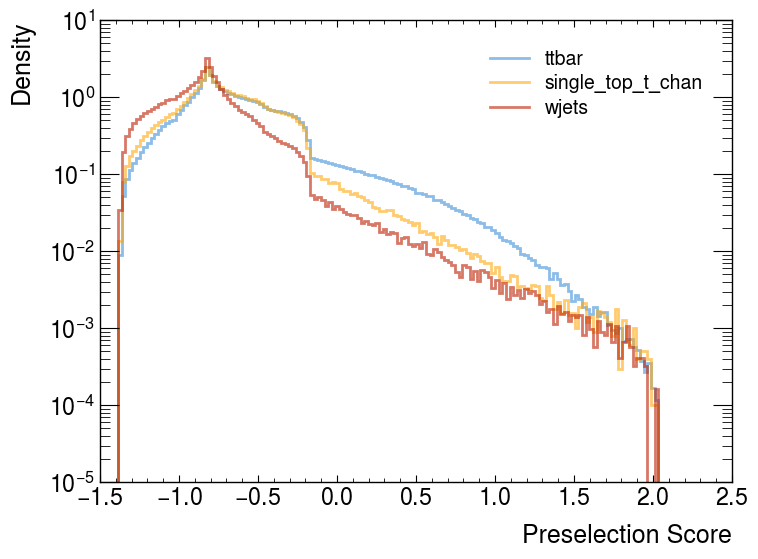

In [69]:
# the preselection score as defined above - log(P_S/P_B)
presel_score = np.log(pred_NN[:, labels_dict["ttbar"]]/(pred_NN[:, labels_dict["single_top_t_chan"]] + pred_NN[:, labels_dict["wjets"]]))

min_pred = np.amin(presel_score)
max_pred = np.amax(presel_score)

bins = np.linspace(min_pred, max_pred, num=150)

hist_NN_output = {}
for key in labels_dict: 
    hist_NN_output[key], _ = np.histogram(presel_score[train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)


for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

Make a selection cut for regions with $p_{ref} \gg 0$ for performing the NSBI analysis. The remaining events - which by definition are background-dominated - can be used as a Control Region for data-driven background estimation, pre-unblinding validations, etc. 

Moreover, the preselections act as a tuning know for the tradeoff in selecting as many signal events as possible to go into the Signal Region (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics). The preselections can also weed out phase space regions with low background statistics to avoid poorly modelled regions. 

Heres a first cut that you can optimize as much as you like to get the desired final results. 

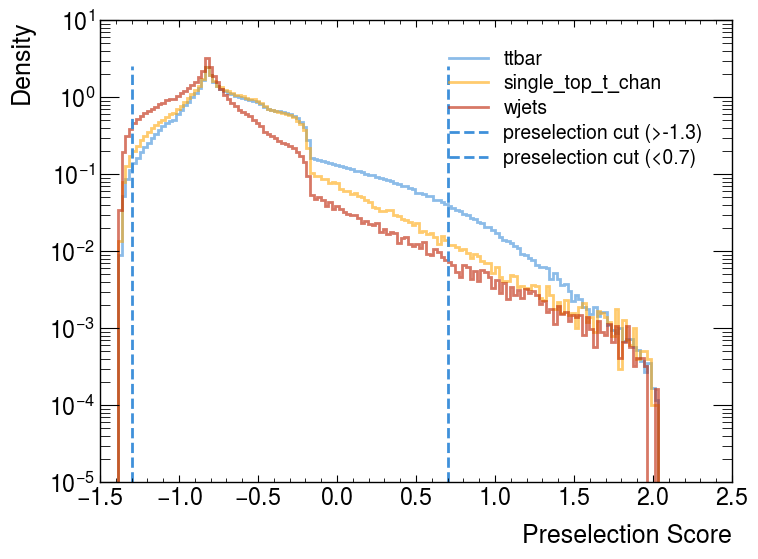

In [73]:
preselection_cut_lower = -1.3
preselection_cut_upper = 0.7

for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.axvline(preselection_cut_lower, ymax=0.9, linestyle='--', label=f'preselection cut (>{preselection_cut_lower})')
plt.axvline(preselection_cut_upper, ymax=0.9, linestyle='--', label=f'preselection cut (<{preselection_cut_upper})')

plt.ylabel("Density", size=18)
plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

In [74]:
# Make the preselections

dataset_incl['presel_score'] = presel_score

dataset = dataset_incl[(dataset_incl.presel_score>=preselection_cut_lower) & (dataset_incl.presel_score<=preselection_cut_upper)].copy()


In [75]:
# Normalizing the training weights post preselection - only discriminating shapes, not norms

weights_normed = dataset['weights'].ravel().copy()
weights = dataset['weights'].ravel().copy()

for key in labels_dict:

    weights_normed[dataset['train_labels_presel']==labels_dict[key]] /= weights[dataset['train_labels_presel']==labels_dict[key]].sum()

dataset['weights_normed'] = weights_normed

In [76]:
# Save the preselected dataframe for inference use later on
dataset.to_hdf(f"{saved_data}dataset_preselected_ttbar.h5", key="dataset", mode='w')


Density ratio training
===

Now we train the NNs for $\frac{p_c}{p_{ref}}(x)$ density ratios to build the full model. Since we chose $p_{t\bar{t}}$ as the reference hypothesis, this leaves us with the estimation of:

$$\frac{p_\text{single top}}{p_{t\bar{t}}}(x) \, , \frac{p_\text{wjets}}{p_{t\bar{t}}}(x)$$

Starting with $\frac{p_\text{wjets}}{p_{t\bar{t}}}(x)$:

In [82]:
# Choose ttbar as the reference hypothesis
dataset_ch_wjets_ref = pd.concat([dataset[dataset['type']=='wjets'], 
                                  dataset[dataset['type']=='ttbar']])

dataset_ch_wjets_ref['train_labels'] = 0
dataset_ch_wjets_ref.loc[dataset_ch_wjets_ref['type']=='ttbar', 'train_labels'] = 1


In [83]:
NN_training_channels_dict = {}


In [84]:

rnd_seed_traintestsplit = 4242
channel_names = ['wjets', 'ttbar']

# Save paths
output_dir = './output_general_wjets/'
output_name = 'first_training_wjets'
path_to_ratios = './output_ratios_wjets/'
path_to_figures = './output_figures_wjets/'
path_to_models = './output_model_params_wjets/'

importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

# Initialize the training class
NN_training_channels_dict['wjets'] = TrainEvaluate_NN(dataset_ch_wjets_ref, 
                                                       dataset_ch_wjets_ref['weights_normed'],
                                                       dataset_ch_wjets_ref['train_labels'],
                                                       columns, 
                                                       columns_scaling, rnd_seed_traintestsplit, 
                                                       channel_names, output_dir, output_name, 
                                                        path_to_figures=path_to_figures,
                                                        path_to_ratios=path_to_ratios, 
                                                        path_to_models=path_to_models)



Here we will start with a multi-layer perceptron (simple feed-forward Neural Network with fully-connected layers). This can be supplemented with more complex architectures like transformers. 

After detailed tuning during the off-shell Higgs boson analysis effort, we found that a network with very wide layers ($\geq 1000$) and a depth of less than 10 works best - alongside batch size of a few hundreds and a gradually declining learning rate that starts with a value just large enough to not blow up.

Sum of weights of class 0: 0.8000011509841863
Sum of weights of class 1: 0.7999877109489445
Using swish activation function
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 1000)              4000      
                                                                 
 dense_28 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_29 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_30 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_31 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 3008001 (11.47 MB)
Trainable params: 3008001 (11

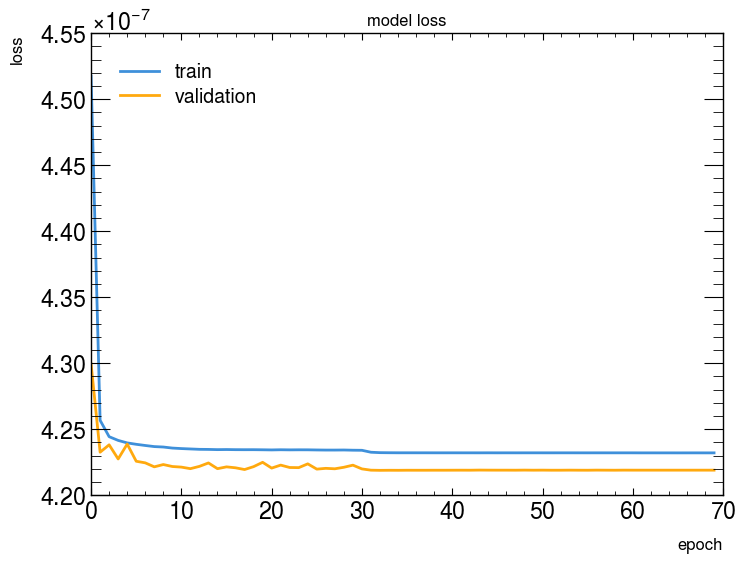

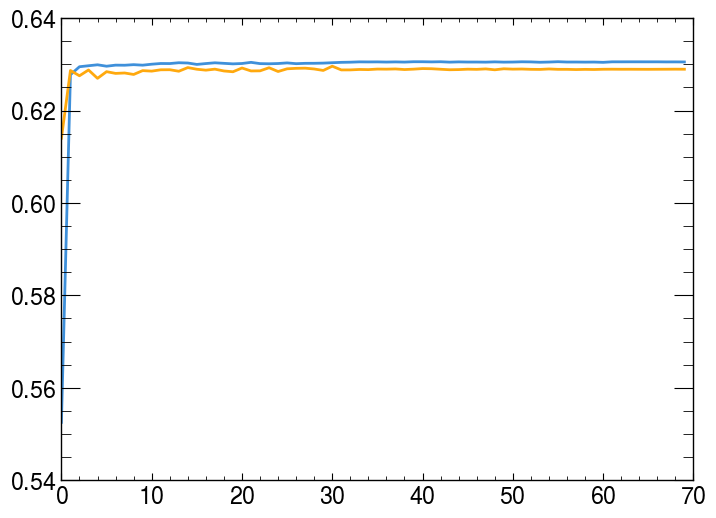

3259/3259 - 2s - 2s/epoch - 615us/step
15739/15739 - 10s - 10s/epoch - 611us/step
13033/13033 - 8s - 8s/epoch - 582us/step
62956/62956 - 39s - 39s/epoch - 617us/step
ttbar training data prediction (max) = 0.8784361
ttbar training data prediction (min) = 0.15344524
wjets training data prediction (max) = 0.8790524
wjets training data prediction (min) = 0.15279578
ttbar training data prediction (max) = 0.87688315
ttbar training data prediction (min) = 0.15516154
wjets training data prediction (max) = 0.8787712
wjets training data prediction (min) = 0.1572205


<Figure size 800x600 with 0 Axes>

In [85]:
# Train the density ratio NN
NN_training_channels_dict['wjets'].train(hidden_layers=4, 
                        neurons=1000, 
                        number_of_epochs=70, 
                        batch_size=1024, 
                        learning_rate=0.1, 
                        scalerType='MinMax', 
                        calibration=False, 
                        num_bins_cal = 10, 
                        callback=True, 
                        callback_patience=30, 
                        callback_factor=0.01)    


Check for overtraining by comparing the NN output distributions between training and holdout datasets. The holdout dataset is the subset of events not used during training.

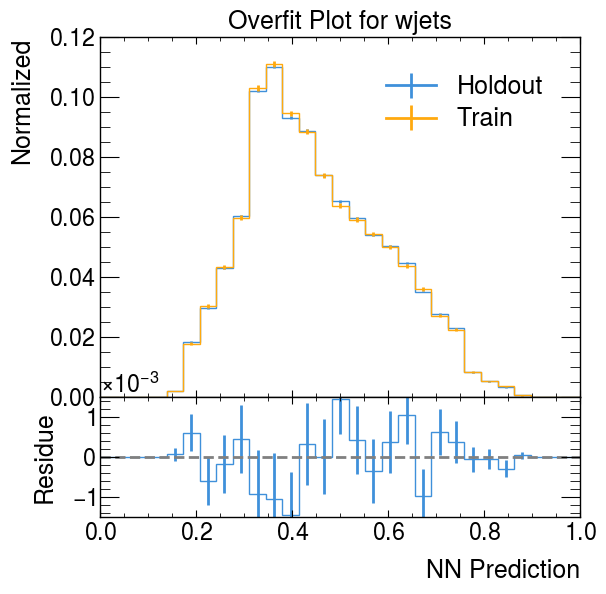

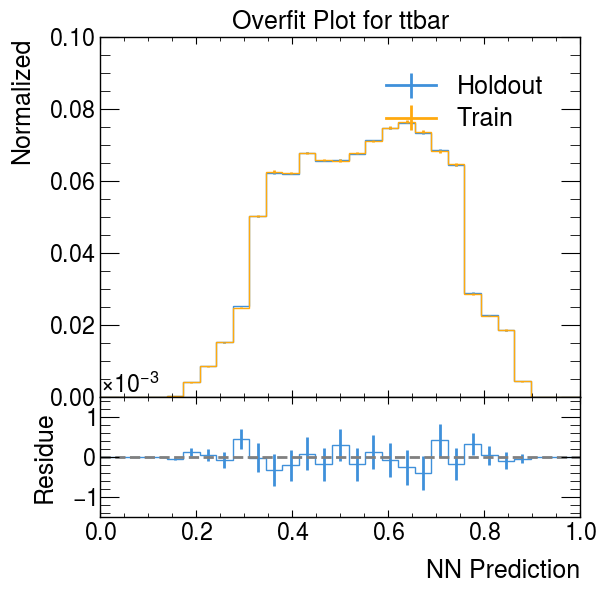

<Figure size 800x600 with 0 Axes>

In [86]:
NN_training_channels_dict['wjets'].make_overfit_plots()

Diagnostic Checks
===

While traditionally, a NN observable is judged on the basis of its accuracy - for NSBI we are interested in the quality of the density ratios more than the discrimination power. The latter comes from the perfect modelling of the multi-dimensional likelihood ratios.

To ensure correct modelling, we run two main checks on the training:

- **Calibration closure test**

  The NNs are trained using the binary cross-entropy loss, which under ideal conditions leads to the NN converging to the score function:

  $$\hat{s}_\text{pred} = \frac{p_\text{ttbar}(x)}{p_\text{ttbar}(x)+p_\text{wjets}(x)}$$

  that can be converted into the probability ratio we desire (likelihood ratio trick):

  $$\frac{p_\text{wjets}(x)}{p_\text{ttbar}(x)} = \frac{s(x)}{1-s(x)}$$

  For the NNs to be well-calibrated, we use the Monte Carlo samples to verify the equality:


  $$\left[\frac{p_c(x)}{p_c(x)+p_{ref}(x)}\right]_\text{NN} \sim \left[\frac{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}}{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}+\mathcal{N}_\text{ref}^{I(x|\hat{s}_\text{pred})}}\right]_\text{MC}$$

  where we bin the events from $p_c$ and $p_\text{ref}$ MC samples, denoted by $\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}$ and $\mathcal{N}_\text{ref}^{I(x|\hat{s}_\text{pred})}$ respectively where $I(x|\hat{s}_\text{pred})$ returns the index of the $\hat{s}_\text{pred}$ bin in which an event $x$ falls.
 


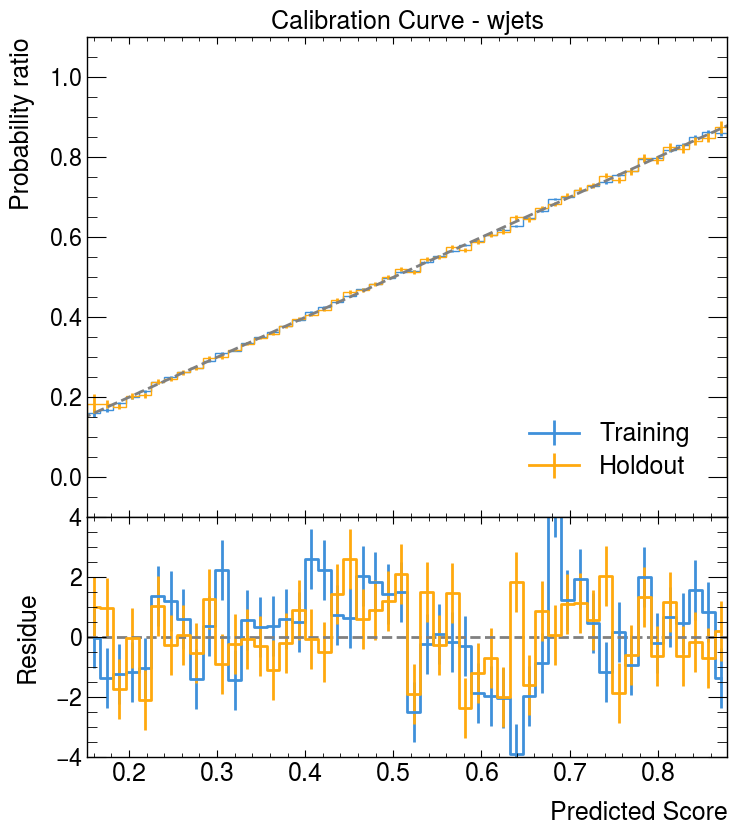

observable not recognized


<Figure size 800x600 with 0 Axes>

In [87]:
num_bins_cal = 50
NN_training_channels_dict['wjets'].make_calib_plots(nbins=num_bins_cal, observable='score')

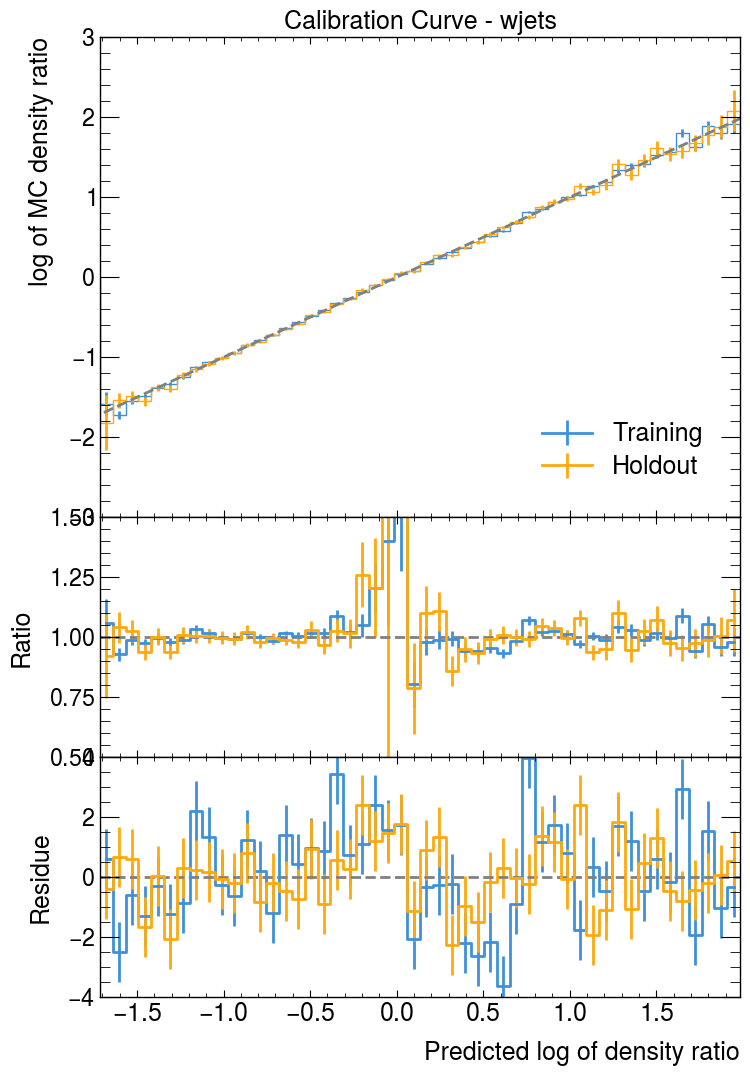

<Figure size 800x600 with 0 Axes>

In [88]:
num_bins_cal = 50
NN_training_channels_dict['wjets'].make_calib_plots(nbins=num_bins_cal, observable='llr')

- **Density ratio reweighting closure tests**
  
  Despite having a well-calibrated output and thus a robust probabilistic interpretation, the trained density ratios might not capture the full multi-dimensional event information $x$. In other words, the NNs might still be biased estimators of the optimal score function, as defined in the CARL paper (link).

  The next diagnostic involves verifying the following equality using 1D projections of $x$:

  $$\frac{p_c(x)}{p_{ref}(x)} \times p_{ref}(x) \sim p_c(x)$$

  We can do this one-by-one for all the observables used to model the density ratios, and also possibly the observables not used directly in the training but can still be well-estimated due to the NN learning the right physics.

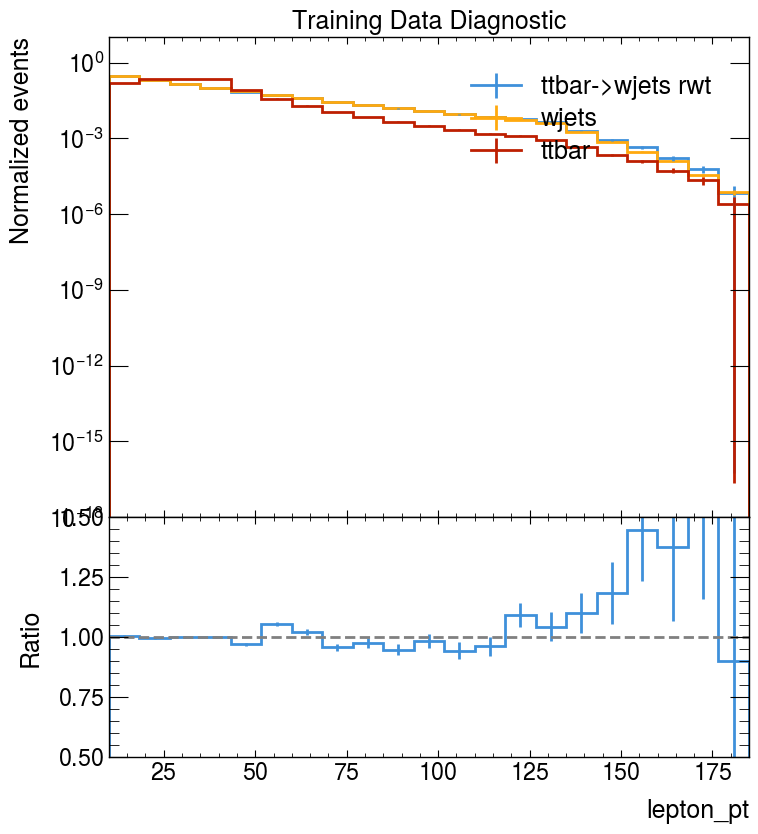

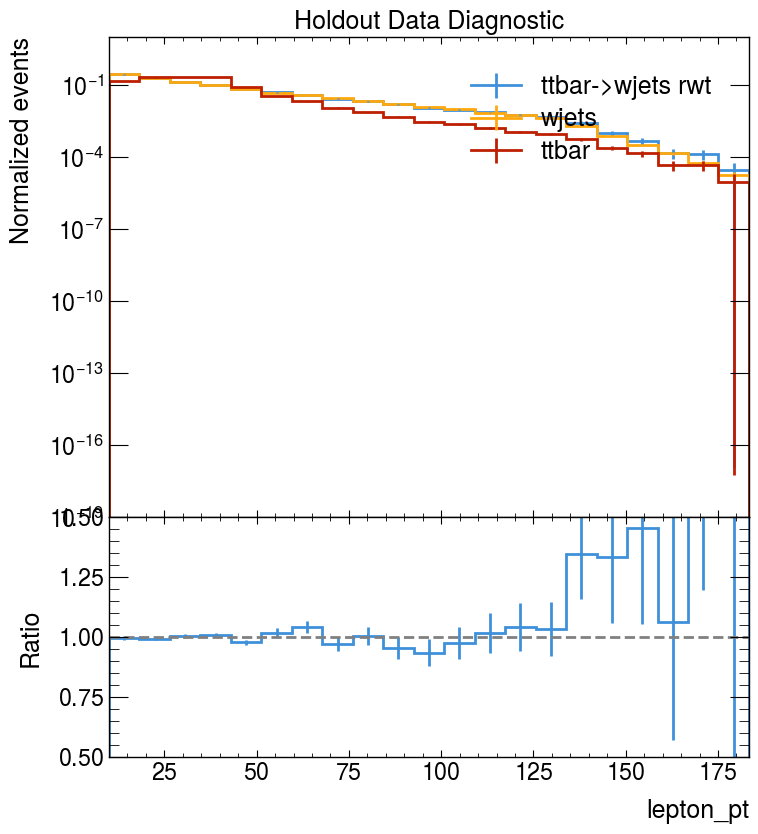

<Figure size 800x600 with 0 Axes>

In [89]:
variables_to_plot=['lepton_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


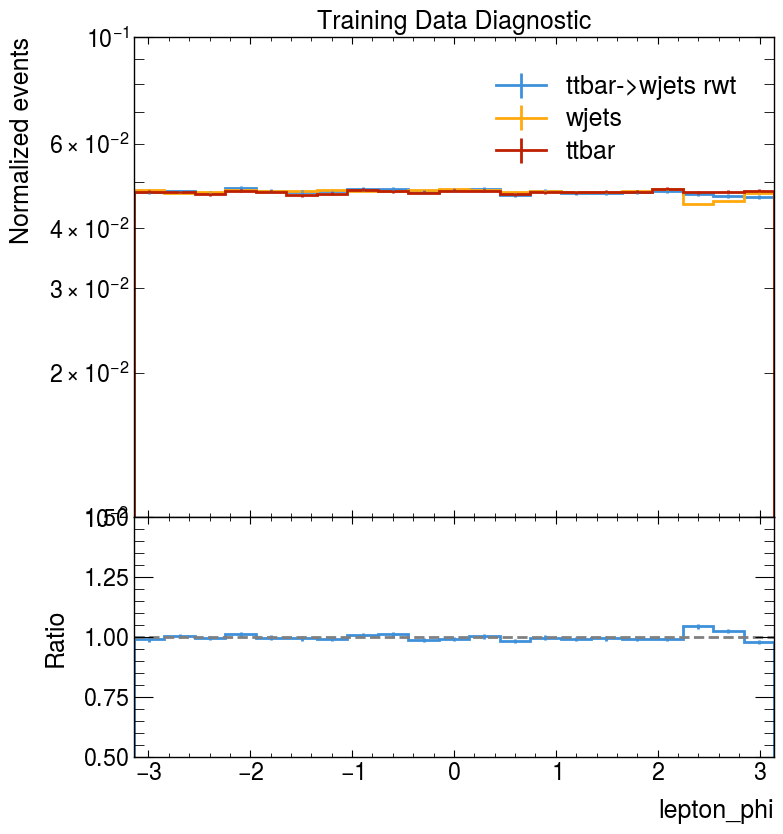

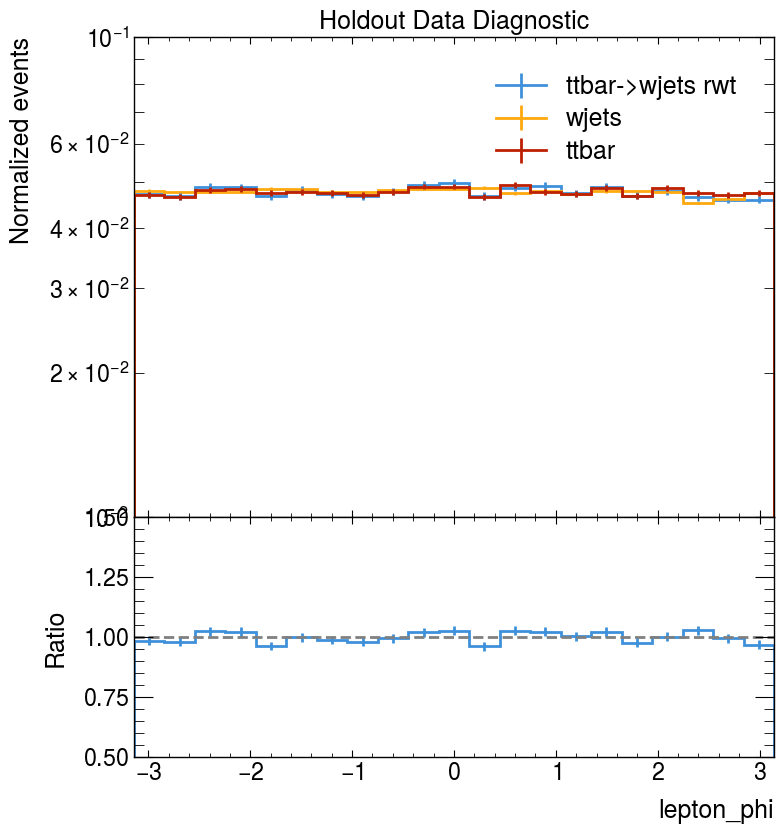

<Figure size 800x600 with 0 Axes>

In [90]:
variables_to_plot=['lepton_phi']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


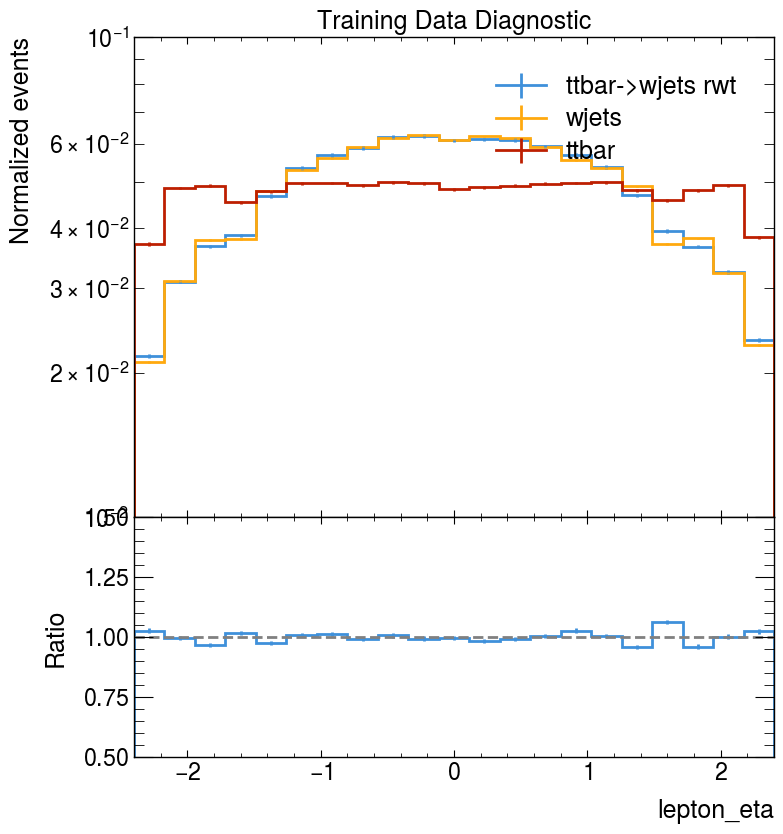

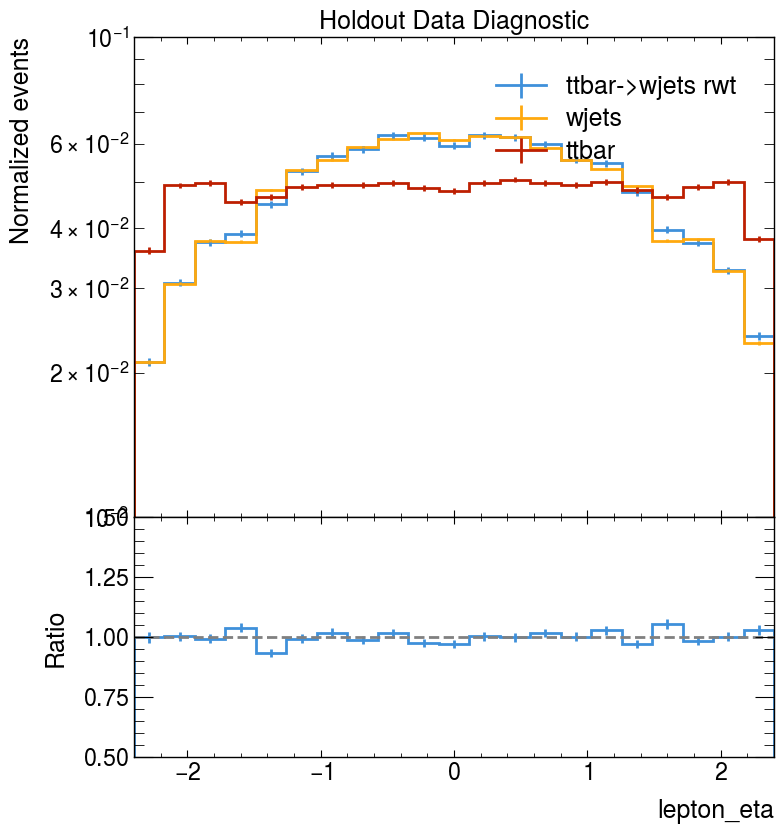

<Figure size 800x600 with 0 Axes>

In [91]:
variables_to_plot=['lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [92]:
# variables_to_plot=['H_T']
# yscale_type='log'
# num_bins_plotting=21

# NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


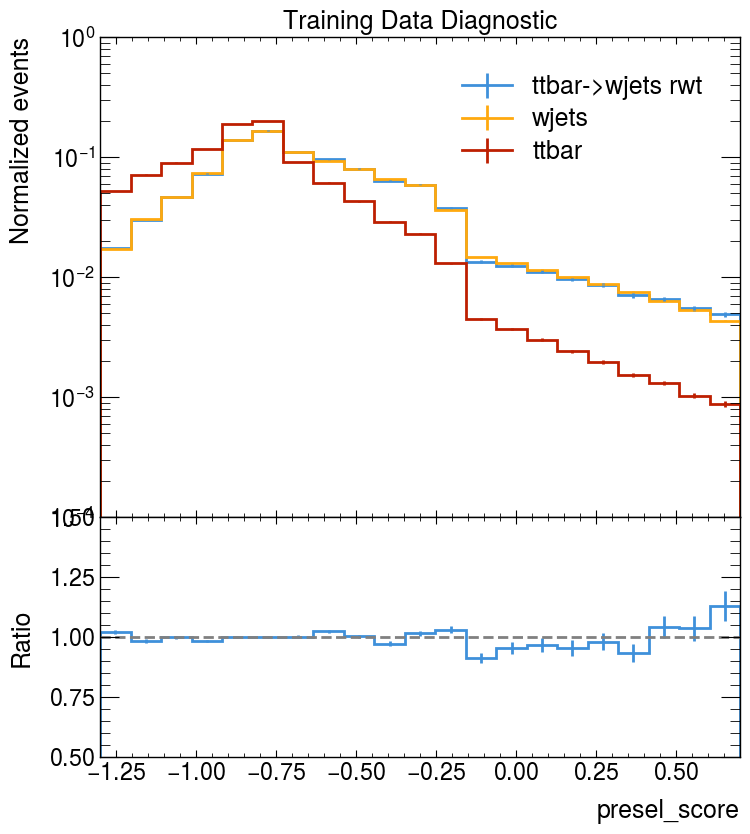

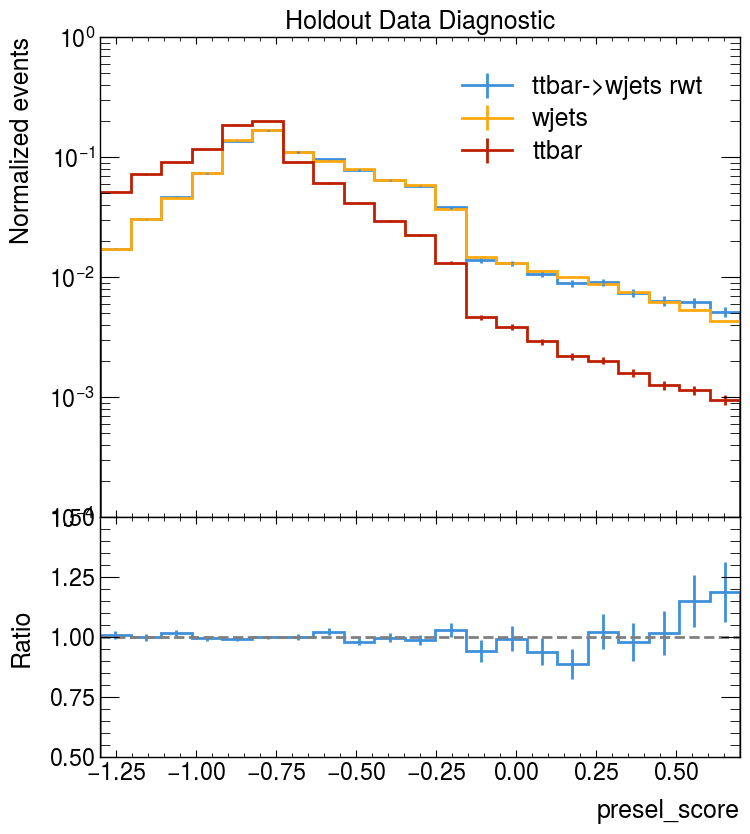

<Figure size 800x600 with 0 Axes>

In [93]:
variables_to_plot=['presel_score']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [94]:
NN_training_channels_dict['wjets'].evaluate_and_save_ratios(dataset)


108444/108444 - 64s - 64s/epoch - 587us/step


In [95]:
# Choose ttbar as the reference hypothesis
dataset_ch_single_top_t_chan_ref = pd.concat([dataset[dataset['type']=='single_top_t_chan'], 
                                              dataset[dataset['type']=='ttbar']])

dataset_ch_single_top_t_chan_ref['train_labels'] = 0
dataset_ch_single_top_t_chan_ref.loc[dataset_ch_single_top_t_chan_ref['type']=='ttbar', 'train_labels'] = 1


In [96]:

rnd_seed_traintestsplit = 42
channel_names = ['single_top_t_chan', 'ttbar']

# Save paths
output_dir = './output_general_singletop/'
output_name = 'first_training_singletop'
path_to_ratios = './output_ratios_singletop/'
path_to_figures = './output_figures_singletop/'
path_to_models = './output_model_params_singletop/'



importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

# Initialize the training class
NN_training_channels_dict['singletop'] = TrainEvaluate_NN(dataset_ch_single_top_t_chan_ref, 
                               dataset_ch_single_top_t_chan_ref['weights_normed'],
                               dataset_ch_single_top_t_chan_ref['train_labels'],
                               columns, 
                               columns_scaling, rnd_seed_traintestsplit, 
                               channel_names, output_dir, output_name, 
                                path_to_figures=path_to_figures,
                                path_to_ratios=path_to_ratios, 
                                path_to_models=path_to_models)



Sum of weights of class 0: 0.800000464402395
Sum of weights of class 1: 0.8000034837465123
Using swish activation function
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 1000)              4000      
                                                                 
 dense_33 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_34 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_35 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_36 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 3008001 (11.47 MB)
Trainable params: 3008001 (11.

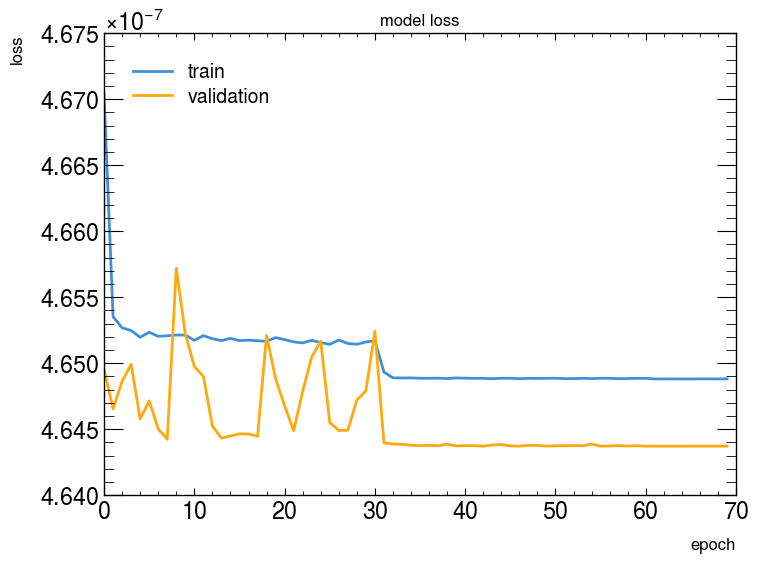

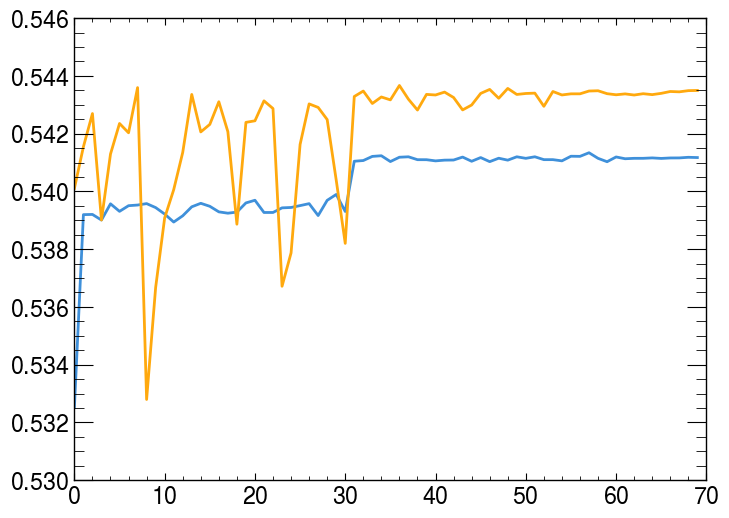

2692/2692 - 2s - 2s/epoch - 628us/step
15739/15739 - 10s - 10s/epoch - 606us/step
10767/10767 - 6s - 6s/epoch - 597us/step
62956/62956 - 37s - 37s/epoch - 589us/step
ttbar training data prediction (max) = 0.7765759
ttbar training data prediction (min) = 0.38124028
single_top_t_chan training data prediction (max) = 0.77717316
single_top_t_chan training data prediction (min) = 0.3813928
ttbar training data prediction (max) = 0.77578855
ttbar training data prediction (min) = 0.38196972
single_top_t_chan training data prediction (max) = 0.7770924
single_top_t_chan training data prediction (min) = 0.3813729


<Figure size 800x600 with 0 Axes>

In [97]:
# Train the density ratio NN
NN_training_channels_dict['singletop'].train(hidden_layers=4, 
                        neurons=1000, 
                        number_of_epochs=70, 
                        batch_size=512, 
                        learning_rate=0.2, 
                        scalerType='MinMax', 
                        calibration=False, 
                        num_bins_cal = 10, 
                        callback=True, 
                        callback_patience=30, 
                        callback_factor=0.01)    


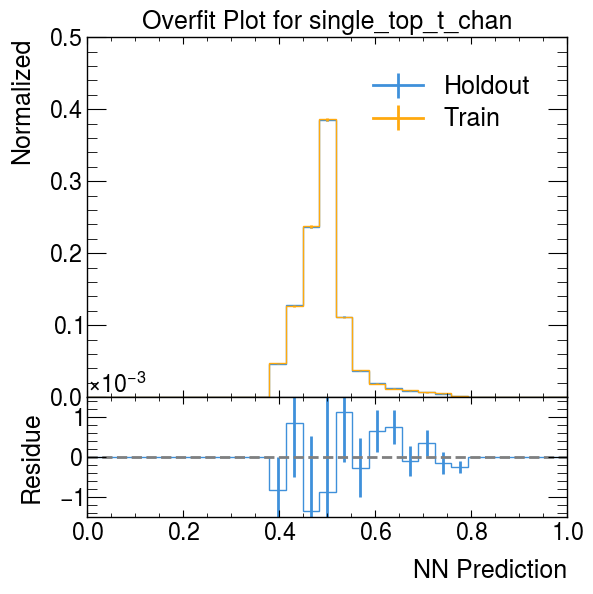

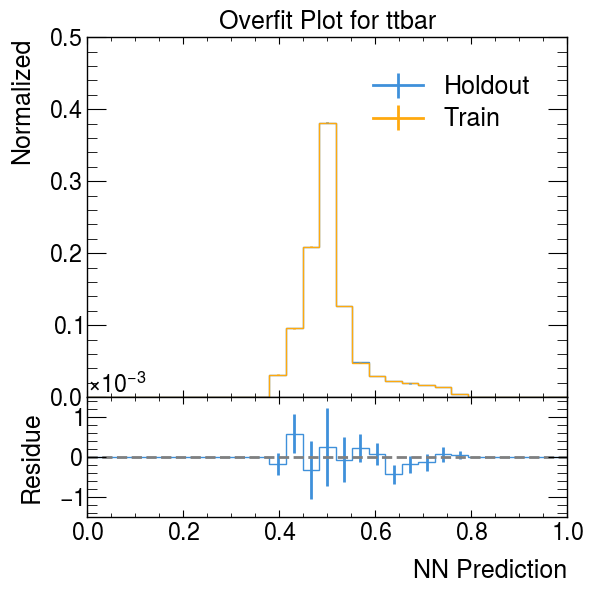

<Figure size 800x600 with 0 Axes>

In [98]:
NN_training_channels_dict['singletop'].make_overfit_plots()

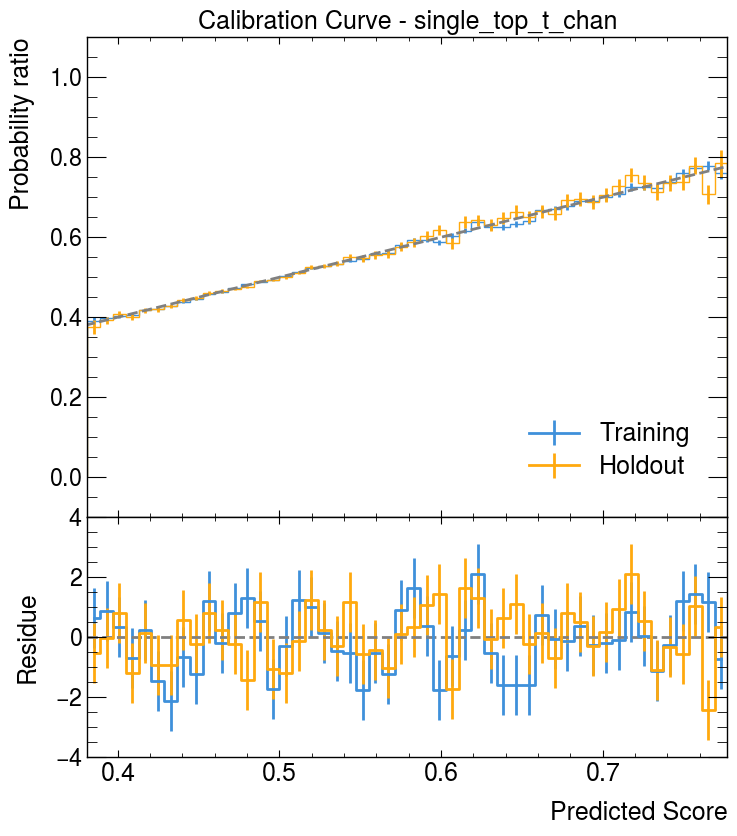

observable not recognized


<Figure size 800x600 with 0 Axes>

In [99]:
num_bins_cal = 50
NN_training_channels_dict['singletop'].make_calib_plots(nbins=num_bins_cal, observable='score')

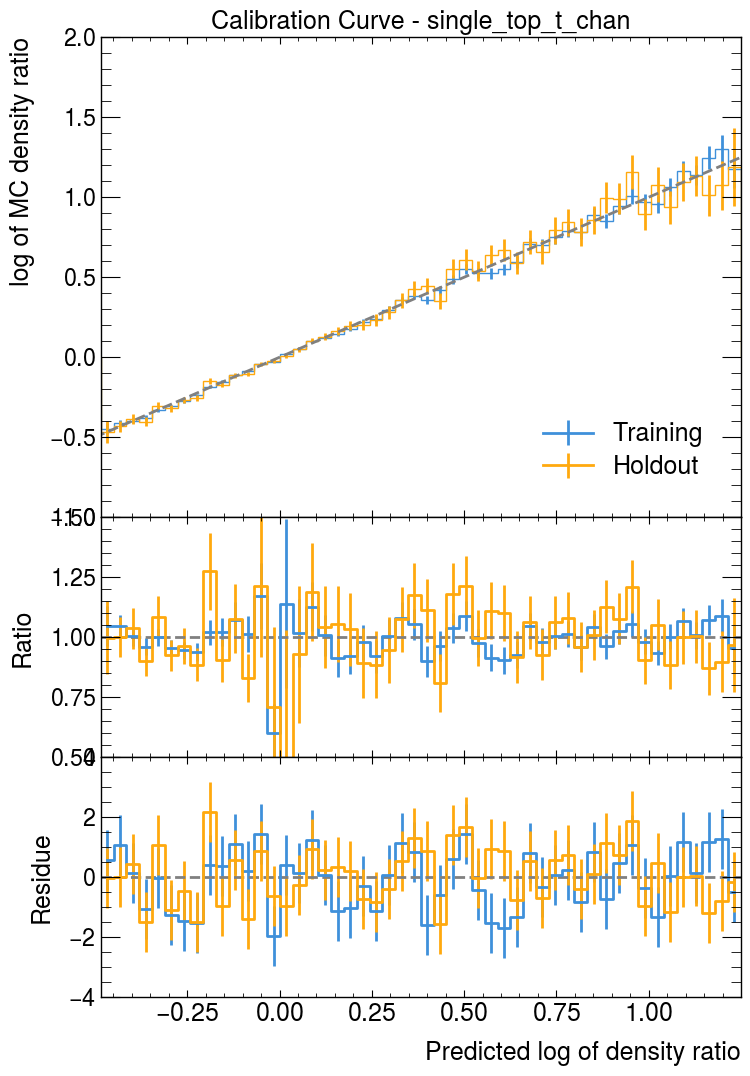

<Figure size 800x600 with 0 Axes>

In [100]:
NN_training_channels_dict['singletop'].make_calib_plots(nbins=num_bins_cal, observable='llr')


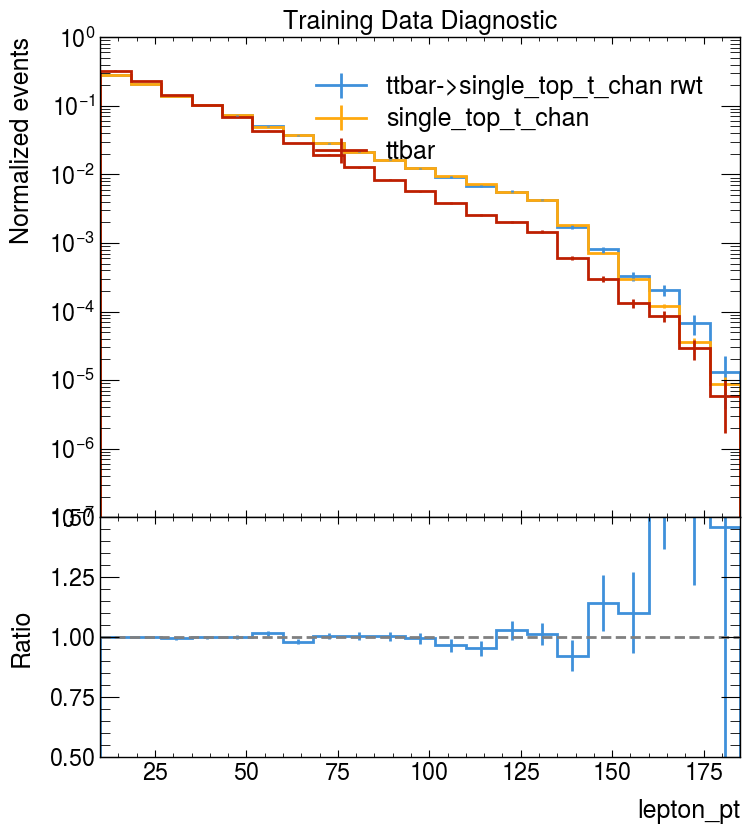

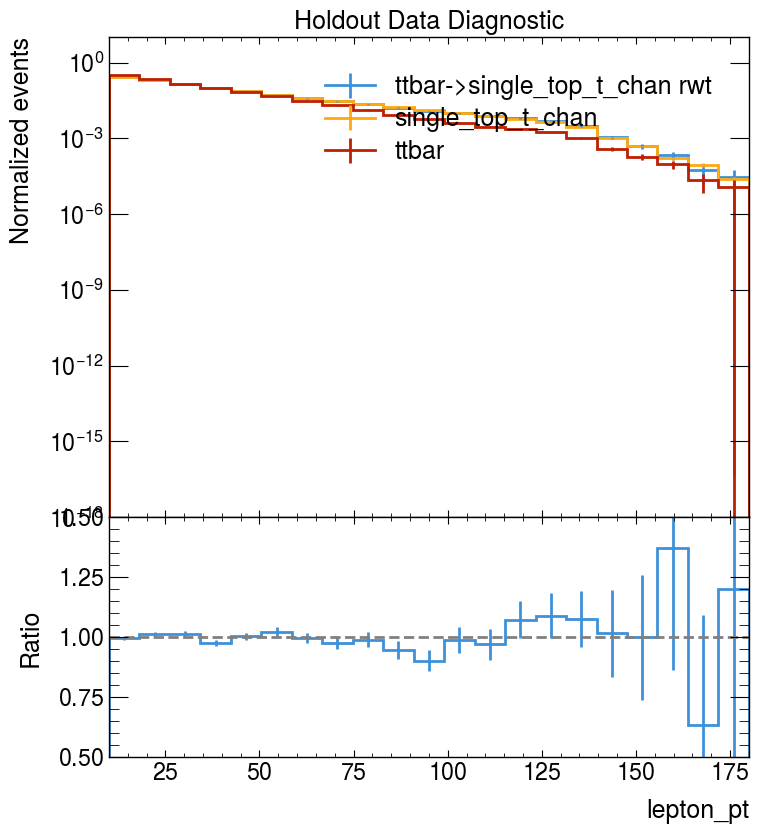

<Figure size 800x600 with 0 Axes>

In [101]:
variables_to_plot=['lepton_pt']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


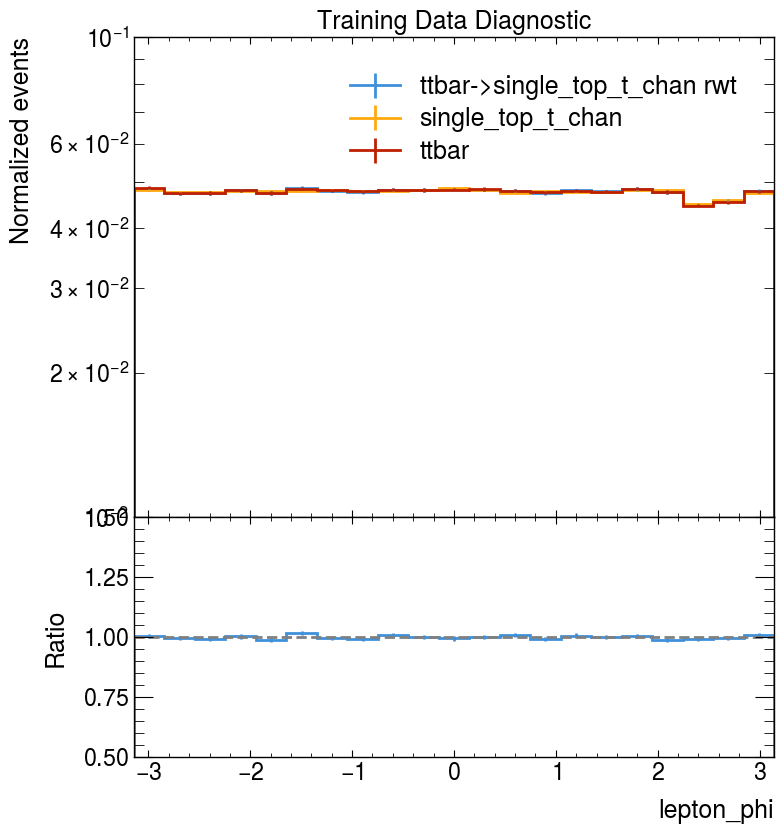

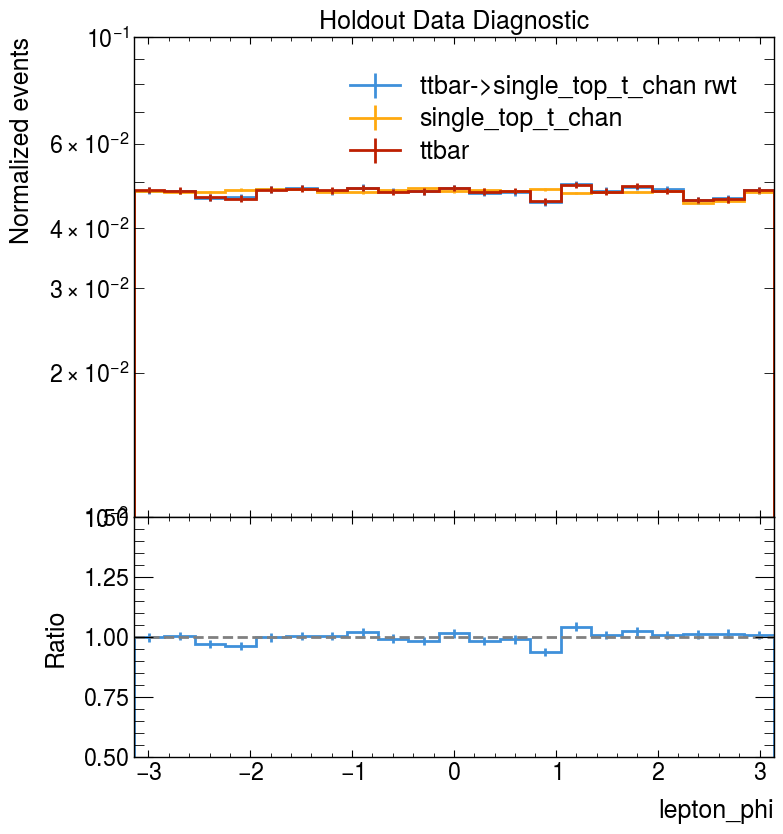

<Figure size 800x600 with 0 Axes>

In [102]:
variables_to_plot=['lepton_phi']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


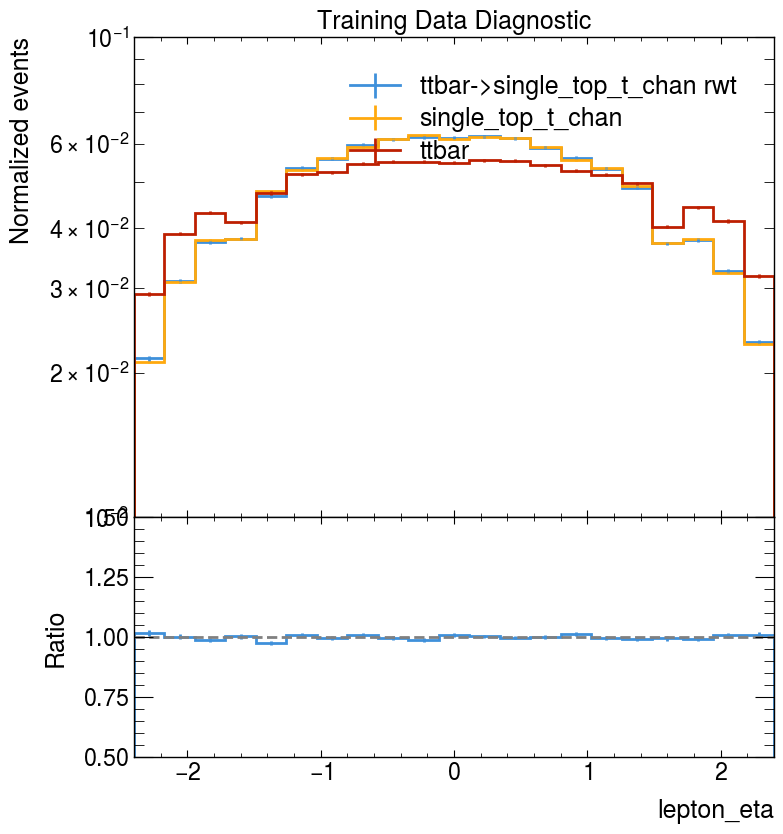

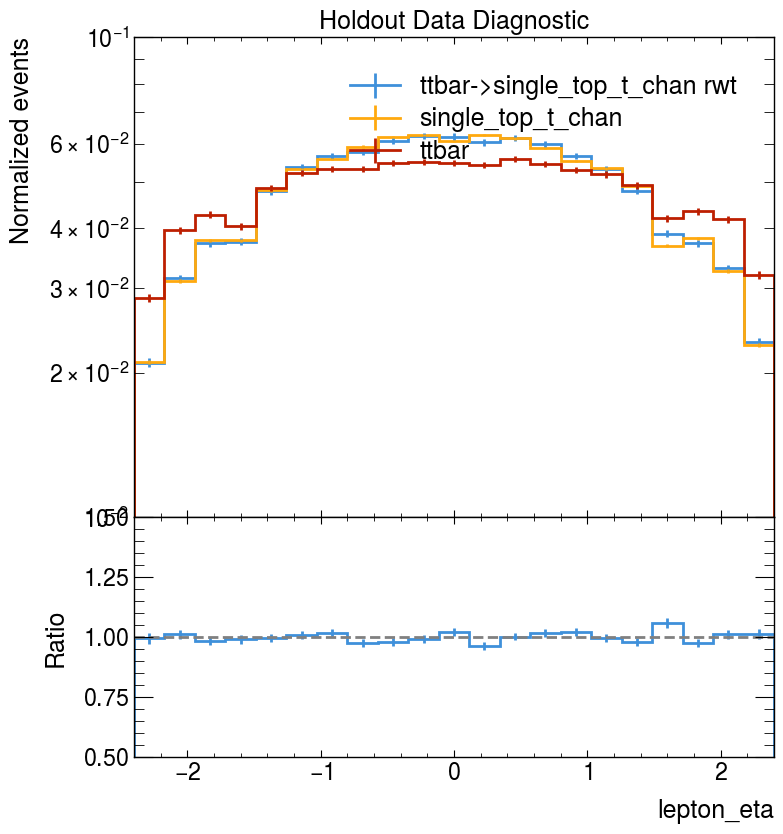

<Figure size 800x600 with 0 Axes>

In [103]:
variables_to_plot=['lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [104]:
# variables_to_plot=['H_T']
# yscale_type='log'
# num_bins_plotting=21

# NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
variables_to_plot=['presel_score']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
NN_training_channels_dict['singletop'].evaluate_and_save_ratios(dataset)


In [55]:
# backup code for updating class methods - only for debugging phase
importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN
import types

NN_training_channels_dict['wjets'].make_reweighted_plots = types.MethodType(TrainEvaluate_NN.make_reweighted_plots, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].make_calib_plots = types.MethodType(TrainEvaluate_NN.make_calib_plots, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].evaluate_and_save_ratios = types.MethodType(TrainEvaluate_NN.evaluate_and_save_ratios, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].make_overfit_plots = types.MethodType(TrainEvaluate_NN.make_overfit_plots, NN_training_channels_dict['wjets'])
